In [1]:
import numpy as np
import polars as pl
import os
from pathlib import Path
from typing import List, Tuple, Union
from datetime import datetime, timedelta
from pydantic import BaseModel
from loguru import logger
from enum import Enum
import random


class EndStatus(Enum):
    DISSIPATED = 0
    MOVE_OUT_OF_RESPONSIBILITY = 1
    MERGED = 2
    NEARLY_STATIONARY = 3


class CycloneCategory(Enum):
    BELOW_TD_OR_UNKNOWN = 0
    TROPICAL_DEPRESSION = 1  # 热带低压 (TD, 10.8-17.1m/s)
    TROPICAL_STORM = 2  # 热带风暴 (TS, 17.2-24.4 m/s)
    SEVERE_TROPICAL_STORM = 3  # 强热带风暴 (STS, 24.5-32.6 m/s)
    TYPHOON = 4  # 台风 (TY, 32.7-41.4 m/s)
    SEVERE_TYPHOON = 5  # 强台风 (STY, 41.5-50.9 m/s)
    SUPER_TYPHOON = 6  # 超强台风 (SuperTY, ≥51.0 m/s)
    EXTRATROPICAL = 9  # 变性 (The change is complete)


class HurricaneHeader(BaseModel):
    data_type: int
    country_code: int
    data_count: int
    hurricane_code: int
    china_hurricane_code: int
    end_status: EndStatus
    time_interval_hr: int
    hurricane_name: str
    dataset_record_time: datetime


class HurricaneEntry(BaseModel):
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


class Hurricane(BaseModel):
    header: HurricaneHeader
    entries: List[HurricaneEntry]


script_folder = Path(os.getcwd())
dataset_folder = script_folder / "CMABSTdata"

# https://tcdata.typhoon.org.cn/zjljsjj.html
# example_file = dataset_folder / "CH2022BST.txt"
example_file = dataset_folder / "CH1950BST.txt"
logger.info(f"example_file: {example_file}")


def parse_header(line: str) -> HurricaneHeader:
    entry = line.split()
    data_type = int(entry[0])
    country_code = int(entry[1])
    data_count = int(entry[2])
    hurricane_code = int(entry[3])
    try:
        china_hurricane_code = int(entry[4])
    except ValueError:
        # might be a tuple (a,b)
        codes = entry[4].split(",")
        china_hurricane_code = int(codes[0])
    hurricane_end_enum = int(entry[5])
    end_status = EndStatus(hurricane_end_enum)
    time_interval_hr = int(entry[6])
    hurricane_name = entry[7]
    dataset_record_time = entry[8]
    time_format = "%Y%m%d"
    dataset_record_time = datetime.strptime(dataset_record_time, time_format)
    return HurricaneHeader(data_type=data_type,
                           country_code=country_code,
                           data_count=data_count,
                           hurricane_code=hurricane_code,
                           china_hurricane_code=china_hurricane_code,
                           end_status=end_status,
                           time_interval_hr=time_interval_hr,
                           hurricane_name=hurricane_name,
                           dataset_record_time=dataset_record_time)


def parse_entry(line: str) -> HurricaneEntry:
    entry = line.split()
    date_str = entry[0]
    time_format = "%Y%m%d%H"
    date = datetime.strptime(date_str, time_format)
    category = int(entry[1])
    hurricane_category = CycloneCategory(category)
    latitude = float(int(entry[2])) / 10.0
    longitude = float(int(entry[3])) / 10.0
    # in hPa
    lowest_pressure = int(entry[4])
    # 2分钟平均近中心最大风速(MSW, m/s)
    # WND=9 表示 MSW < 10m/s,
    # WND=0 为缺测
    wind_speed = int(entry[5])
    # not sure about OWD
    return HurricaneEntry(date=date,
                          category=hurricane_category,
                          latitude=latitude,
                          longitude=longitude,
                          lowest_pressure=lowest_pressure,
                          wind_speed=wind_speed)


def parse_dataset(filename):
    hurricanes: list[Hurricane] = []
    with open(filename, "r") as f:
        try:
            while True:
                # check if the line is empty
                l = f.readline()
                if not l:
                    break
                header = parse_header(l)
                count = header.data_count
                hurricane_entries = []
                for i in range(count):
                    entry = parse_entry(f.readline())
                    hurricane_entries.append(entry)
                hurricane = Hurricane(header=header, entries=hurricane_entries)
                hurricanes.append(hurricane)
        except ValueError as e:
            logger.error(f"ValueError: {e} for {filename}")
        except IndexError as e:
            logger.warning(f"IndexError: {e} for {filename}")
        except EOFError:
            logger.info(f"EOFError for {filename}")
    return hurricanes



2024-04-07 19:32:01.156 | INFO     | __main__:<module>:63 - example_file: d:\毕业论文\数据集\hurricane_stuff-1\CMABSTdata\CH1950BST.txt


In [2]:
total_dataset: list[Hurricane] = []

for file in dataset_folder.glob("*.txt"):
    hurricanes = parse_dataset(file)
    total_dataset.extend(hurricanes)

logger.info(f"total_dataset: {len(total_dataset)}")

2024-04-07 19:32:02.976 | INFO     | __main__:<module>:7 - total_dataset: 2469


In [3]:
class FlatHurricaneEntry(BaseModel):
    sample_id: int
    name: str
    china_hurricane_code: int
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


def flat_hurricane_entries(
        hurricanes: list[Hurricane]) -> List[FlatHurricaneEntry]:
    counter = 0
    def flat_one(h: Hurricane, counter: int = counter):
        name = h.header.hurricane_name
        hurricane_code = h.header.hurricane_code
        entries = h.entries
        return [
            FlatHurricaneEntry(sample_id=counter,
                               name=name,
                               china_hurricane_code=hurricane_code,
                               date=e.date,
                               category=e.category,
                               latitude=e.latitude,
                               longitude=e.longitude,
                               lowest_pressure=e.lowest_pressure,
                               wind_speed=e.wind_speed) for e in entries
        ]

    entries = []
    for h in hurricanes:
        entries.extend(flat_one(h, counter))
        counter += 1
    return entries


flatten_entries = [
    e.model_dump() for e in flat_hurricane_entries(total_dataset)
]


def entry_enum_to_number(entry: dict[str, any]) -> dict[str, any]:
    entry['category'] = entry['category'].value
    return entry


flatten_entries_without_enum = [
    entry_enum_to_number(e) for e in flatten_entries
]

In [4]:
df = pl.DataFrame(flatten_entries_without_enum)
df_filtered = df.filter(df["wind_speed"] != 0)
df_filtered.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",65796.0,"""65796""",65796.0,"""65796""",65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1307.737796,null,17.502265,"""1985-09-05 05:…",2.866664,20.73495,133.459558,984.894963,25.891893
"""std""",699.270657,null,10.381192,null,2.121499,8.752285,16.292624,21.13435,14.21218
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-15 00:…",0.0,0.5,95.0,870.0,8.0
"""25%""",731.0,null,9.0,"""1968-06-01 00:…",1.0,14.5,121.2,975.0,15.0
"""50%""",1337.0,null,17.0,"""1984-10-31 00:…",2.0,19.4,131.7,992.0,20.0
"""75%""",1918.0,null,25.0,"""2003-06-17 18:…",4.0,25.5,143.9,1000.0,35.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1016.0,110.0


In [5]:
#df_filtered.write_csv('hurricane.csv')

In [6]:
import math
time = df["date"][6]
assert isinstance(time, datetime)
# use sin/cos to normalize the day in a year and the hour in a day

def sinusoidal_hour_in_day(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the hour of day from a datetime object.
    """
    # Extract the hour from the datetime object
    hour = dt.hour

    # Calculate the radians for the given hour
    radians_per_hour = 2 * math.pi / 24
    hour_in_radians = hour * radians_per_hour

    # Return the sine and cosine values
    return math.sin(hour_in_radians), math.cos(hour_in_radians)

def sinusoidal_day_in_year(dt: datetime) -> tuple[float, float]:
    """
    Return sin and cos corresponding to the day of year from a datetime object.
    """
    # Extract the day of year from the datetime object
    day_of_year = dt.timetuple().tm_yday

    # Handle leap years
    year_length = 366 if dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0) else 365

    # Calculate the radians for the given day of year
    radians_per_day = 2 * math.pi / year_length
    day_in_radians = day_of_year * radians_per_day

    # Return the sine and cosine values
    return math.sin(day_in_radians), math.cos(day_in_radians)

logger.info(f"{time} -> {sinusoidal_hour_in_day(time)} {sinusoidal_day_in_year(time)}")

2024-04-07 19:32:07.325 | INFO     | __main__:<module>:37 - 1949-01-14 12:00:00 -> (1.2246467991473532e-16, -1.0) (0.2386727660059501, 0.9711000518829505)


In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# longitude and latitude
lat_long_scaler = MinMaxScaler()
latitude = lat_long_scaler.fit_transform(df_filtered["latitude"].to_numpy().reshape(-1, 1)).reshape(-1)
longitude = lat_long_scaler.fit_transform(df_filtered["longitude"].to_numpy().reshape(-1, 1)).reshape(-1)

# wind speed
wind_scaler = StandardScaler()
wind_speed = wind_scaler.fit_transform(df_filtered["wind_speed"].to_numpy().reshape(-1, 1)).reshape(-1)

# lowest pressure
lowest_pressure_scaler = StandardScaler()
lowest_pressure = lowest_pressure_scaler.fit_transform(df_filtered["lowest_pressure"].to_numpy().reshape(-1, 1)).reshape(-1)

In [8]:
with_normalized_time = df_filtered.with_columns([
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[0]).alias("sin_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_day_in_year(x)[1]).alias("cos_day_in_year"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[0]).alias("sin_hour_in_day"),
    df_filtered["date"].map_elements(lambda x: sinusoidal_hour_in_day(x)[1]).alias("cos_hour_in_day"),
    pl.Series("latitude_norm", latitude),
    pl.Series("longitude_norm", longitude),
    pl.Series("wind_speed_norm", wind_speed),
    pl.Series("lowest_pressure_norm", lowest_pressure),
])

df_features = with_normalized_time.select([
    "sample_id",
    "sin_day_in_year",
    "cos_day_in_year",
    "sin_hour_in_day",
    "cos_hour_in_day",
    "latitude_norm",
    "longitude_norm",
    "wind_speed_norm",
    "lowest_pressure_norm",
])

In [9]:
df_features.height
df_features.describe()

statistic,sample_id,sin_day_in_year,cos_day_in_year,sin_hour_in_day,cos_hour_in_day,latitude_norm,longitude_norm,wind_speed_norm,lowest_pressure_norm
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1307.737796,-0.498177,-0.264362,0.006157,0.003637,0.290732,0.258291,7.5743e-17,-2.4023e-16
"""std""",699.270657,0.550623,0.615432,0.705854,0.708332,0.125751,0.10942,1.000008,1.000008
"""min""",0.0,-0.999991,-1.0,-1.0,-1.0,0.0,0.0,-1.258922,-5.43645
"""25%""",731.0,-0.927542,-0.809017,0.0,-0.707107,0.201149,0.175957,-0.766383,-0.468197
"""50%""",1337.0,-0.699458,-0.413279,1.2246e-16,6.1232e-17,0.271552,0.246474,-0.41457,0.336187
"""75%""",1918.0,-0.263665,0.209315,1.0,1.0,0.359195,0.328408,0.640871,0.71472
"""max""",2468.0,0.999991,1.0,1.0,1.0,1.0,1.0,5.918075,1.471788


In [10]:
from numpy.typing import NDArray
from functools import reduce
# group by sample_id and iterate over the groups
grouped = df_features.group_by("sample_id")
from typing import Iterable, Iterator, Tuple, Union

EXPECTED_TIMESTAMP_COUNT = 20


def filter_out_short_sequence(id_and_df: tuple[int, pl.DataFrame]) -> bool:
    return id_and_df[1].height >= EXPECTED_TIMESTAMP_COUNT


def pad_or_truncate(
        id_and_df: tuple[int, pl.DataFrame]) -> tuple[pl.Series, pl.DataFrame]:
    group_id, df = id_and_df
    if df.height < EXPECTED_TIMESTAMP_COUNT:
        # pad with zeros
        diff = EXPECTED_TIMESTAMP_COUNT - df.height
        mask = pl.Series("mask", [True] * df.height + [False] * diff)
        zeros = pl.DataFrame({
            "sample_id": [group_id] * diff,
            "sin_day_in_year": [0.0] * diff,
            "cos_day_in_year": [0.0] * diff,
            "sin_hour_in_day": [0.0] * diff,
            "cos_hour_in_day": [0.0] * diff,
            "latitude_norm": [0.0] * diff,
            "longitude_norm": [0.0] * diff,
            "wind_speed_norm": [0.0] * diff,
            "lowest_pressure_norm": [0.0] * diff,
        })
        stacked = df.vstack(zeros)
        # sort by date
        return mask, stacked.sort("date")
    elif df.height >= EXPECTED_TIMESTAMP_COUNT:
        # truncate
        mask = pl.Series("mask", [True] * EXPECTED_TIMESTAMP_COUNT)
        return mask, df.head(EXPECTED_TIMESTAMP_COUNT)
    else:
        mask = pl.Series("mask", [True] * df.height)
        return mask, df


filtered = filter(filter_out_short_sequence, grouped)
padded = map(pad_or_truncate, filtered)


# for some reason, the reduce function is not working
def to_tensor(
        id_and_df: Iterable[tuple[int,
                                  pl.DataFrame]]) -> tuple[NDArray, NDArray]:
    init_mask, init_data = np.empty(
        (0, EXPECTED_TIMESTAMP_COUNT, 1)), np.empty(
            (0, EXPECTED_TIMESTAMP_COUNT, df_features.width))
    for mask, df in id_and_df:
        current_data = df.to_numpy()
        current_mask = np.expand_dims(mask.to_numpy(), axis=-1)
        try:
            new_data = np.vstack(
                (init_data, np.expand_dims(current_data, axis=0)))
            new_mask = np.vstack(
                (init_mask, np.expand_dims(current_mask, axis=0)))
        except ValueError as e:
            logger.error(f"ValueError: {e}")
            logger.info(
                f"init_data: {init_data.shape}, current_data: {current_data.shape}"
            )
            logger.info(
                f"init_mask: {init_mask.shape}, current_mask: {current_mask.shape}"
            )
            logger.info(
                f"init_data: {init_data}, current_data: {current_data}")
            logger.info(
                f"init_mask: {init_mask}, current_mask: {current_mask}")

        init_data, init_mask = new_data, new_mask
    return init_data, init_mask


data_with_id, mask = to_tensor(padded)
# remove the sample_id column
features = data_with_id[:, :, 1:]
display((features.shape, mask.shape))

# y_train should be the last 4 features
y_train = features[:, -10:, -4:]
X_train = features[:, :10, :]
display((X_train.shape, y_train.shape))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12316\1895117370.py:44: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['sample_id'])`.
  filtered = filter(filter_out_short_sequence, grouped)


((1599, 20, 8), (1599, 20, 1))

((1599, 10, 8), (1599, 10, 4))

In [11]:
import torch.nn as nn
from torch.nn.utils import weight_norm
 
 
class Crop(nn.Module):
 
    def __init__(self, crop_size):
        super(Crop, self).__init__()
        self.crop_size = crop_size
 
    def forward(self, x):
        return x[:, :, :-self.crop_size].contiguous()
 
 
class TemporalCasualLayer(nn.Module):
 
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout = 0.2):
        super(TemporalCasualLayer, self).__init__()
        padding = (kernel_size - 1) * dilation
        conv_params = {
            'kernel_size': kernel_size,
            'stride':      stride,
            'padding':     padding,
            'dilation':    dilation
        }
 
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, **conv_params))
        self.crop1 = Crop(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
 
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, **conv_params))
        self.crop2 = Crop(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
 
        self.net = nn.Sequential(self.conv1, self.crop1, self.relu1, self.dropout1,
                                 self.conv2, self.crop2, self.relu2, self.dropout2)
        #shortcut connect
        self.bias = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
 
    def forward(self, x):
        y = self.net(x)
        b = x if self.bias is None else self.bias(x)
        return self.relu(y + b)
 
 
class TemporalConvolutionNetwork(nn.Module):
 
    def __init__(self, num_inputs, num_channels, kernel_size = 2, dropout = 0.2):
        super(TemporalConvolutionNetwork, self).__init__()
        layers = []
        num_levels = len(num_channels)
        tcl_param = {
            'kernel_size': kernel_size,
            'stride':      1,
            'dropout':     dropout
        }
        for i in range(num_levels):
            dilation = 2**i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            tcl_param['dilation'] = dilation
            tcl = TemporalCasualLayer(in_ch, out_ch, **tcl_param)
            layers.append(tcl)
 
        self.network = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.network(x)
 
 
class TCN(nn.Module):
 
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvolutionNetwork(input_size, num_channels, kernel_size = kernel_size, dropout = dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
 
    def forward(self, x):
        y = self.tcn(x)#[N,C_out,L_out=L_in]
        return self.linear(y[:, :, -1])


In [12]:
import random
import numpy as np
 
 
def generate_time_series(len):
    backshift = 10
    # np.random.random(size=None)
    # Return random floats in the half-open interval [0.0, 1.0).
    r1 = np.random.random(len + backshift)
    r2 = np.random.random(len + backshift)
 
    # random.choices(population,weights=None,*,cum_weights=None,k=1)
    # 从population中随机选取k次数据，返回一个列表，可以设置权重。 
    # 注意：每次选取都不会影响原序列，每一次选取都是基于原序列。
    # 参数weights设置相对权重，它的值是一个列表，设置之后，每一个成员被抽取到的概率就被确定了。
    # 比如weights=[1,2,3,4,5],那么第一个成员的概率就是P=1/(1+2+3+4+5)=1/15。
    # cum_weights设置累加权重，Python会自动把相对权重转换为累加权重，即如果你直接给出累加权重，
    # 那么就不需要给出相对权重，且Python省略了一步执行。
    # 比如weights=[1,2,3,4],那么cum_weights=[1,3,6,10]
    # 这也就不难理解为什么cum_weights=[1,1,1,1,1]输出全是第一个成员1了。
    rm = [random.choices([0, 0, 0, 1])[0]
          for _ in range(len + backshift)]
 
    ts = np.zeros([len + backshift, 4])
    for i in range(backshift, len + backshift):
        ts[i, 1] = r1[i]
        ts[i, 2] = r2[i]
        ts[i, 3] = rm[i]
 
        ts[i, 0] = ts[i - 1, 0] -\
                   (r1[i - 1] + r1[i - 2]) +\
                   4 * r2[i - 3] * (rm[i - 4] + rm[i - 6])
 
    return ts[backshift:]

In [13]:
import os
 
import pandas as pd
import torch
 
 
def sliding_window(ts, features, target_len = 1):
    X = []
    Y = []
    # 产生的样本x为：[(i-target_len) - features,i - target_len)
    # y为：[i-target_len,i)
    # 可以看出，这里产生的样本是用过去历史上features个时刻的信息去
    # 去预测未来target_len(这里target_len=1)个时刻
    for i in range(features + target_len, len(ts) + 1):
        X.append(ts[(i-target_len) - features:i - target_len])
        Y.append(ts[i - target_len:i])
 
    return X, Y
 
 
# 对时间序列做差分处理
def ts_diff(ts):
    diff_ts = [0] * len(ts)
    for i in range(1, len(ts)):
        diff_ts[i] = ts[i] - ts[i - 1]
    return diff_ts
 
# 从预测出的各个时刻的差分值还原出实际的各个时刻的值
def ts_int(ts_diff, ts_base, start = 0):
    ts = []
    for i in range(len(ts_diff)):
        if i == 0:
            ts.append(start + ts_diff[0])
        else:
            ts.append(ts_diff[i] + ts_base[i - 1])
    return ts
 
 
def get_aep_timeseries():
    dir_path = os.path.dirname(os.path.realpath(__file__))
    df = pd.read_csv(f'{dir_path}/data/AEP_hourly.csv')
    ts = df['AEP_MW'].astype(int).values.reshape(-1, 1)[-3000:]
    return ts
 
 
def get_pjme_timeseries():
    dir_path = os.path.dirname(os.path.realpath(__file__))
    df = pd.read_csv(f'{dir_path}/data/PJME_hourly.csv')
    ts = df['PJME_MW'].astype(int).values.reshape(-1, 1)[-3000:]
    return ts
 
 
def get_ni_timeseries():
    dir_path = os.path.dirname(os.path.realpath(__file__))
    df = pd.read_csv(f'{dir_path}/data/NI_hourly.csv')
    ts = df['NI_MW'].astype(int).values.reshape(-1, 1)[-3000:]
    return ts
 
 
def get_training_datasets(ts, features, test_len, train_ratio = .7, target_len = 1):
    X, Y = sliding_window(ts, features, target_len)
 
    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]
 
    train_len = round(len(ts) * train_ratio)
 
    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]
 
    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()
 
    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()
 
    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()
 
    return x_train, x_val, x_test, y_train, y_val, y_test

In [14]:
import torch.nn as nn
 
# dummy prediction model (Y_t= Y_{t-1})
class Dummy(nn.Module):
 
    def __init__(self):
        super(Dummy, self).__init__()
 
    def forward(self, x):# x(x_test):[n_test,4,features]
        return x[:, 0, -1].unsqueeze(1)# 返回值形状：[n_test,1]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12316\2072814512.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  x_train = torch.tensor(data = X_train).float()
d:\Software\envs\pytorch\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch 0. train: 2.5857, val: 2.5655
epoch 100. train: 0.2655, val: 0.2308
epoch 200. train: 0.1002, val: 0.1061
epoch 300. train: 0.0337, val: 0.052
epoch 400. train: 0.0099, val: 0.0145
epoch 500. train: 0.0148, val: 0.0248
epoch 600. train: 0.0079, val: 0.0139
epoch 700. train: 0.0036, val: 0.0061
epoch 800. train: 0.0401, val: 0.0576
epoch 900. train: 0.0022, val: 0.004


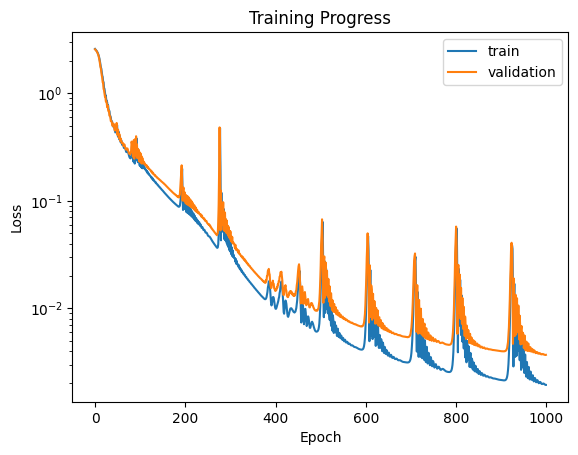

d:\Software\envs\pytorch\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


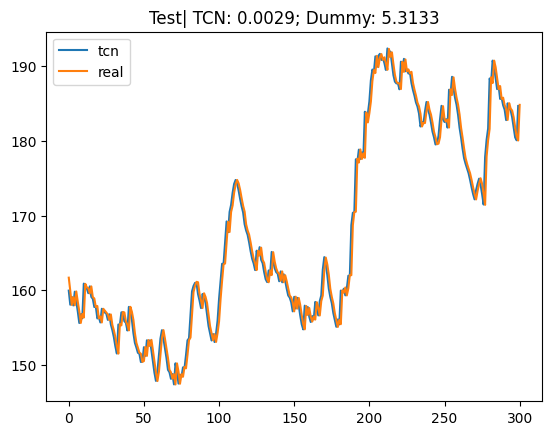

In [16]:
import copy
import random
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
 
import numpy as np
import matplotlib.pyplot as plt
 
import torch
 
#from dummy import Dummy
#from model import TCN
#from ts import generate_time_series
#from training_datasets import get_training_datasets, ts_diff, ts_int
 
seed = 12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
 
# time series input
features = 20
# training epochs
epochs = 1_000
# synthetic time series dataset
ts_len = 5_000
# test dataset size
test_len = 300
# temporal casual layer channels
channel_sizes = [10] * 4
# convolution kernel size
kernel_size = 5
dropout = .0
 
ts = generate_time_series(ts_len)
 
# 对时间序列进行差分处理
ts_diff_y = ts_diff(ts[:, 0])
ts_diff = copy.deepcopy(ts)
ts_diff[:, 0] = ts_diff_y
 
# x:[N,features,4],y:[N,1,1]
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(ts_diff, features, test_len)
# [n_train,4,features]
x_train = x_train.transpose(1, 2)
# [n_val,4,features]
x_val = x_val.transpose(1, 2)
# [n_test,4,features]
x_test = x_test.transpose(1, 2)
 
# [N,1]
y_train = y_train[:, :, 0]
y_val = y_val[:, :, 0]
y_test = y_test[:, :, 0]
 
# device = torch.device("cuda")
# for x in [x_train,x_val,x_test,y_train,y_val,y_test]:
#     x = x.to(device)
 
train_len = x_train.size()[0]
 
model_params = {
    # 'input_size',C_in
    'input_size':   4,
    # 单步，预测未来一个时刻
    'output_size':  1,
    'num_channels': channel_sizes,
    'kernel_size':  kernel_size,
    'dropout':      dropout
}
model = TCN(**model_params)
# model = model.to(device)
 
optimizer = torch.optim.Adam(params = model.parameters(), lr = .005)
mse_loss = torch.nn.MSELoss()
 
best_params = None
min_val_loss = sys.maxsize
 
training_loss = []
validation_loss = []
 
for t in range(epochs):
 
    prediction = model(x_train)
    loss = mse_loss(prediction, y_train)
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    val_prediction = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)
 
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
 
    if val_loss.item() < min_val_loss:
        best_params = copy.deepcopy(model.state_dict())
        min_val_loss = val_loss.item()
 
    if t % 100 == 0:
        diff = (y_train - prediction).view(-1).abs_().tolist()
        print(f'epoch {t}. train: {round(loss.item(), 4)}, '
              f'val: {round(val_loss.item(), 4)}')
 
plt.title('Training Progress')
plt.yscale("log")
plt.plot(training_loss, label = 'train')
plt.plot(validation_loss, label = 'validation')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()# 图例
plt.show()
 
best_model = TCN(**model_params)
best_model.eval()
best_model.load_state_dict(best_params)
 
tcn_prediction = best_model(x_test)
dummy_prediction = Dummy()(x_test)
 
tcn_mse_loss = round(mse_loss(tcn_prediction, y_test).item(), 4)
dummy_mse_loss = round(mse_loss(dummy_prediction, y_test).item(), 4)
 
plt.title(f'Test| TCN: {tcn_mse_loss}; Dummy: {dummy_mse_loss}')
plt.plot(
    ts_int(
        tcn_prediction.view(-1).tolist(),
        ts[-test_len:, 0],
        start = ts[-test_len - 1, 0]
    ),
    label = 'tcn')
plt.plot(ts[-test_len-1:, 0], label = 'real')
plt.legend()
plt.show()